In [94]:
import os
import wrds
import quandl
import zipfile
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import numpy as np 
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.cm as cm
import datetime as dt
pd.options.display.float_format = '{:.6f}'.format

## Helper Functions

In [95]:
BASE_DIR = Path(os.getcwd()).resolve()
DATA_DIR = BASE_DIR / "Data"
print(f'Base Directory: \n {BASE_DIR}')
print(f'Data Directory: \n {DATA_DIR}')

Base Directory: 
 /Users/kaleembukhari/Documents/Kaleem's Data/University of Chicago/GitHubRepositories/TE-Portfolio-Stress-Testing-Final-Project
Data Directory: 
 /Users/kaleembukhari/Documents/Kaleem's Data/University of Chicago/GitHubRepositories/TE-Portfolio-Stress-Testing-Final-Project/Data


In [188]:
def get_wrds_data(sql_query, start_date, end_date):
    """
    Retrieve data from WRDS using a SQL query with a date filter.

    Parameters:
    - sql_query (str): The SQL query with placeholders for date range filtering.
    - start_date (str): The start date for filtering (format: 'YYYY-MM-DD').
    - end_date (str): The end date for filtering (format: 'YYYY-MM-DD').

    Returns:
    - pd.DataFrame: The resulting data from the query.
    """
    try:
        db = wrds.Connection()
        formatted_query = sql_query.format(start_date=start_date, end_date=end_date)
        data = db.raw_sql(formatted_query)
        db.close()
        data['date'] = pd.to_datetime(data['date'])
        data.set_index('date', inplace = True)
        return data

    except Exception as e:
        print(f"Error retrieving data: {e}")
        return None

def weighted_portfolio_returns(asset_returns_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the weighted portfolio returns.

    Parameters:
    - asset_returns_df (pd.DataFrame): DataFrame where each column is the return series of an asset.

    Returns:
    - pd.DataFrame: A DataFrame with the weighted portfolio return series as a single column.
    """
    asset_returns_df_copy = asset_returns_df.copy()
    num_assets = len(asset_returns_df_copy.columns)
    weight_vector = np.ones(num_assets) / num_assets
    portfolio_returns = asset_returns_df_copy.values @ weight_vector
    portfolio_returns_df = pd.DataFrame({'Portfolio_Returns': portfolio_returns}, index=asset_returns_df_copy.index)
    return portfolio_returns_df

def fama_french_regression(factors, portfolio_excess_return, shifter_=1):
    """
    Perform the Fama-French multi-factor regression.

    Parameters:
    - factors (pd.DataFrame): A DataFrame containing the Fama-French factors with the following columns:
    - portfolio_excess_return (pd.Series): A Series of the portfolio's excess returns over the risk-free rate.

    Returns:
    - pd.DataFrame: A DataFrame containing the beta coefficients for each factor, including the constant.
    """
    X = sm.add_constant(factors)
    Y = portfolio_excess_return
    model = sm.OLS(Y, X, missing='drop').fit()
    print(model.summary())
    results_df = pd.DataFrame({'Coefficient': model.params})
    return results_df

## Section 5: Constructing a Generalized Factor Model to stress test portfolio performance

## 5.1. Model Development Plan

### Two-Step Approach
This framework is designed to evaluate the impact of macroeconomic variables on portfolio performance under both normal and stressed economic cycles. To achieve this, we develop two distinct multivariate regression models.

Including macroeconomic variables alongside Fama-French factors in a single model to assess portfolio performance is not ideal due to multicollinearity issues among independent variables. For instance, the Market Factor reflects overall market performance, which is inherently influenced by economic conditions. Correlated explanatory variables violate the assumptions of regression models, compromising robustness.

To address this, we adopt a two-step approach to build a generalized factor model for assessing portfolio performance. This approach will also be used for stress-testing portfolio performance.

### Mechanics of the Two-Step Model Approach:
- **Model 1 - Portfolio Returns Factor Model**
Construct a factor model using the Fama-French factors, along with additional factors such as Momentum, Profitability, and Investment. This model assesses the impact of these factors on portfolio performance.

- **Model 2 - Factors vs Macroeconomic Varibales**: 
Develop a second model to analyze the relationship between macroeconomic variables and the individual factors used as independent variables in Model 1. Macroeconomic data will be transformed as necessary to ensure stationarity. Given that some macroeconomic variables have lagging effects on economic outcomes, appropriate lags will be incorporated to capture these dynamics effectively.

### Exposure Calculation
The portfolio return is regressed on factor exposures:

$$R_t - R_f = \alpha + \sum_{i} \beta_i \cdot F_{i,t} + \epsilon_t $$
Where:
- $R_t$: Portfolio return at time $t$
- $R_f$: Risk-free rate
- $\beta_i$: Portfolio exposure to factor $i$
- $F_{i,t}$: Return of factor $i$ at time $t$
- $\alpha$: Portfolio-specific alpha
- $\epsilon_t$: Residual term


Each factor is modeled as a function of macroeconomic variables:

$$F_{i,t} = \delta_i + \sum_{j} \gamma_{i,j} \cdot M_{j,t} + \eta_{i,t}$$
Where:
- $F_{i,t}$: Return of factor $i$ at time $t$
- $\delta_i$: Intercept term for factor $i$
- $\gamma_{i,j}$: Sensitivity of factor $i$ to macroeconomic variable $j$
- $M_{j,t}$: Macroeconomic variable $j$ at time $t$
- $\eta_{i,t}$: Residual term for factor $i$


The combined portfolio exposure to macroeconomic variables is given by:

$$\text{Portfolio Exposure} = \sum_{i} \beta_i \cdot \gamma_{i,j}$$
Where:
- $\beta_i$: Portfolio exposure to factor $i$ (from Step 1)
- $\gamma_{i,j}$: Sensitivity of factor $i$ to macroeconomic variable $j$ (from Step 2)


In [97]:
# Fama French Sql Query
fama_french_sql_query = """
            SELECT date, 
                   mktrf AS MKT, 
                   smb AS SMB, 
                   hml AS HML,
                   rmw AS PROFT,
                   cma AS INVST,
                   rf AS RFR,
                   umd AS MMNTM
            FROM ff_all.fivefactors_monthly
            WHERE date BETWEEN '{start_date}' AND '{end_date}'
            ORDER BY date;
            """

In [98]:
start_date = '1976-01-01'
end_date = '2024-12-31'
ff_6_factors = get_wrds_data(fama_french_sql_query, start_date, end_date)

WRDS recommends setting up a .pgpass file.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [99]:
ff_6_factors.head()

,mkt,smb,hml,proft,invst,rfr,mmntm
date,,,,,,,
1976-01-01,0.121600,0.063400,0.086300,-0.017900,0.022800,0.004700,0.044500
1976-02-01,0.003200,0.079900,0.058700,-0.026400,0.038700,0.003400,0.003800
1976-03-01,0.023200,-0.013800,-0.001200,-0.003300,0.009600,0.004000,0.001500
1976-04-01,-0.014900,0.000800,-0.001600,0.004000,-0.011000,0.004200,0.005900
1976-05-01,-0.013400,-0.011000,-0.013600,0.024600,-0.014100,0.003700,-0.011200


### Saving Fama-French 5 Factors plus Momentum Data
- Data type: Returns
- Frequency: Monthly resample to Quarterly

In [140]:
ff_6_factors = ff_6_factors.resample('QS').mean()

In [141]:
ff_6_factors_file = 'ff_6_factors.csv'
ff_6_factors.to_csv(DATA_DIR/ff_6_factors_file, index = True)

In [142]:
ff_6_factors.head()

,mkt,smb,hml,proft,invst,rfr,mmntm
date,,,,,,,
1976-01-01,0.049333,0.043167,0.047933,-0.015867,0.023700,0.004033,0.016600
1976-04-01,0.004067,-0.006967,-0.002700,0.007267,-0.004967,0.004067,-0.003167
1976-07-01,0.001467,-0.004167,0.007500,-0.001633,-0.004733,0.004433,-0.002533
1976-10-01,0.011967,0.021433,0.012000,-0.007367,0.006667,0.004033,0.010667
1977-01-01,-0.024533,0.027600,0.019433,-0.003233,0.005633,0.003633,0.016367


In [143]:
portfolio_file_ = 'portfolio_returns.csv'
prtf_rets = pd.read_csv(DATA_DIR/portfolio_file_)
prtf_rets['Date'] = pd.to_datetime(prtf_rets['Date'])
prtf_rets = prtf_rets[prtf_rets['Date'] >= pd.Timestamp('1976-01-01')]
prtf_rets.set_index('Date', inplace = True)
prtf_rets = prtf_rets.resample('QS').mean()
prtf_rets.head()

,ARCHER-DANIELS-MIDLAND CO,BANK OF AMERICA CORP,CONAGRA BRANDS INC,COLGATE-PALMOLIVE CO,CAMPBELL SOUP CO,JOHNSON & JOHNSON,JPMORGAN CHASE & CO,KELLANOVA,COCA-COLA CO,LILLY (ELI) & CO,MERCK & CO,PFIZER INC,PROCTER & GAMBLE CO,TYSON FOODS INC -CL A,WALMART INC
Date,,,,,,,,,,,,,,,
1976-01-01,-0.043200,0.083100,0.131433,-0.010600,0.008733,0.004600,0.086633,-0.013167,0.028867,0.023833,0.028933,0.033233,0.009400,0.037033,0.077400
1976-04-01,0.073667,-0.037133,0.024533,-0.004800,-0.025200,-0.020867,0.033867,0.089067,-0.010967,-0.006967,-0.009267,-0.002700,0.018700,0.020833,-0.054700
1976-07-01,-0.104200,0.000633,-0.007700,0.009100,0.031433,0.026167,-0.006233,0.019833,0.009600,0.017733,0.031233,0.014667,0.008133,-0.061867,0.051367
1976-10-01,0.021533,0.058200,0.034400,0.005933,0.057967,-0.046667,0.039567,0.013033,-0.024567,-0.041700,-0.039900,-0.002600,-0.008533,-0.018167,0.002700
1977-01-01,-0.068267,-0.000800,0.032333,-0.026900,-0.013300,-0.045733,-0.013700,-0.043667,-0.005133,-0.034267,-0.063933,-0.010333,-0.052567,0.047800,-0.034200


### Getting weighted portfolio returns

In [144]:
wghtd_prtf_rets = weighted_portfolio_returns(prtf_rets)
wghtd_prtf_rets.head()

,Portfolio_Returns
Date,
1976-01-01,0.032416
1976-04-01,0.005871
1976-07-01,0.002660
1976-10-01,0.003413
1977-01-01,-0.022178


In [145]:
prtfs_rets_ff_fctr = pd.merge(wghtd_prtf_rets, ff_6_factors, 
                              how = 'inner', left_index = True, right_index = True)
prtfs_rets_ff_fctr['Portfolio_Excess_Returns'] = prtfs_rets_ff_fctr['Portfolio_Returns'] - prtfs_rets_ff_fctr['rfr']
prtfs_rets_ff_fctr = prtfs_rets_ff_fctr.resample('QS').mean()
prtfs_rets_ff_fctr.head()

,Portfolio_Returns,mkt,smb,hml,proft,invst,rfr,mmntm,Portfolio_Excess_Returns
1976-01-01,0.032416,0.049333,0.043167,0.047933,-0.015867,0.023700,0.004033,0.016600,0.028382
1976-04-01,0.005871,0.004067,-0.006967,-0.002700,0.007267,-0.004967,0.004067,-0.003167,0.001804
1976-07-01,0.002660,0.001467,-0.004167,0.007500,-0.001633,-0.004733,0.004433,-0.002533,-0.001773
1976-10-01,0.003413,0.011967,0.021433,0.012000,-0.007367,0.006667,0.004033,0.010667,-0.000620
1977-01-01,-0.022178,-0.024533,0.027600,0.019433,-0.003233,0.005633,0.003633,0.016367,-0.025811


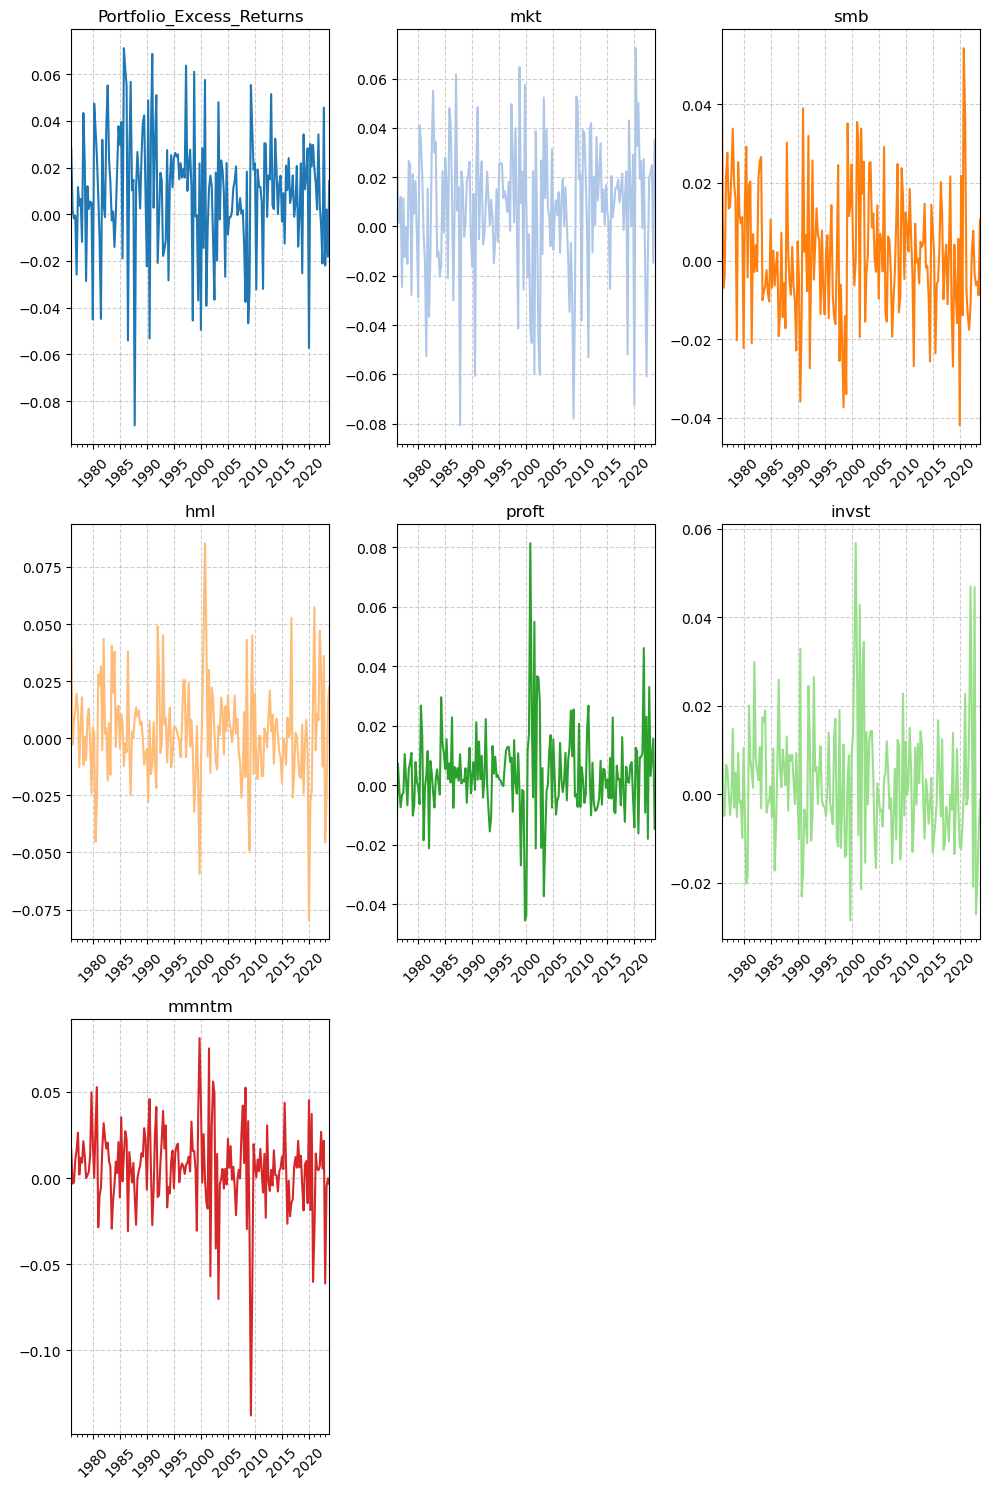

In [147]:
n_cols = 3
n_rows = (len(vars_to_plot) + n_cols - 1) // n_cols 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))
axes = axes.flatten()

colors = cm.tab20.colors

for i, var_ in enumerate(vars_to_plot):
    color = colors[i % len(colors)]
    prtfs_rets_ff_fctr[var_].plot(ax=axes[i], color=color)
    axes[i].set_title(var_)
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels
    axes[i].grid(True, linestyle='--', alpha=0.6)  # Add grid lines for readability

for j in range(len(vars_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [204]:
factors_df = prtfs_rets_ff_fctr[['mkt', 'smb', 'hml', 'proft', 'invst', 'mmntm']].shift(1)
prtf_exs_rets_df = prtfs_rets_ff_fctr[['Portfolio_Excess_Returns']]
model_1_results = fama_french_regression(factors_df, prtf_exs_rets_df)

                               OLS Regression Results                               
Dep. Variable:     Portfolio_Excess_Returns   R-squared:                       0.041
Model:                                  OLS   Adj. R-squared:                  0.010
Method:                       Least Squares   F-statistic:                     1.325
Date:                      Tue, 19 Nov 2024   Prob (F-statistic):              0.248
Time:                              21:30:45   Log-Likelihood:                 429.37
No. Observations:                       191   AIC:                            -844.7
Df Residuals:                           184   BIC:                            -822.0
Df Model:                                 6                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [ ]:
def compute_predictions_with_actual(parameters_df, factors_df, annualizing_factor):
    # Extract intercept and coefficients
    intercept = parameters_df.loc['const', 'Coefficient'] * annualizing_factor
    betas = parameters_df.drop('const')['Coefficient']
    
    # Compute predictions
    predictions = intercept + factors_df @ betas

    # Create the results DataFrame
    prediction_df = pd.DataFrame({'Predicted': predictions}, index=factors_df.index).dropna()
    
    return prediction_df


In [219]:
prediction_df = compute_predictions_with_actual(model_1_results, factors_df,1)
model1_preds = pd.merge(prediction_df, prtf_exs_rets_df, how = 'inner', left_index=True, right_index=True)
model1_preds

,Predicted,Portfolio_Excess_Returns
1976-04-01,-0.002786,0.001804
1976-07-01,0.013278,-0.001773
1976-10-01,0.013868,-0.000620
1977-01-01,0.003851,-0.025811
1977-04-01,0.001173,0.011658
...,...,...
2022-10-01,0.012592,0.045720
2023-01-01,0.000928,-0.021936
2023-04-01,0.020313,0.002042
2023-07-01,0.013902,-0.018156


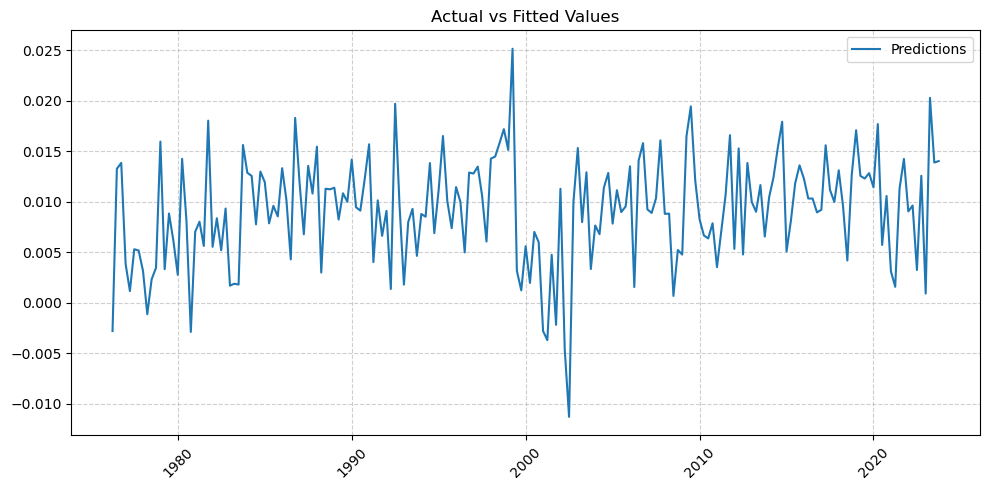

In [223]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))

#axes.plot(model1_preds.index, model1_preds['Portfolio_Excess_Returns'], label='Actual')
axes.plot(model1_preds.index, model1_preds['Predicted'], label='Predictions')
axes.set_title("Actual vs Fitted Values")
axes.legend()
axes.grid(True, linestyle='--', alpha=0.6)
axes.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()